In [1]:
###build MLP from zero
import torch
from torch import nn
from d2l import torch as d2l

In [71]:
batchsize=256
train,test=d2l.load_data_fashion_mnist(batchsize) 

D:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [44]:
##relu
def Relu(X): #@save
    a=torch.zeros_like(X)
    return torch.maximum(X,a)

##net parameters
input_n=28*28
hidden_n1=64
hidden_n2=16
#hidden_n3=8
output_n=10
lr=0.1

w1=nn.Parameter(torch.normal(0,0.01,size=(input_n,hidden_n1),requires_grad=True))
b1=nn.Parameter(torch.zeros((1,hidden_n1),requires_grad=True))

w2=nn.Parameter(torch.normal(0,0.01,size=(hidden_n1,hidden_n2),requires_grad=True))
b2=nn.Parameter(torch.zeros((1,hidden_n2),requires_grad=True))

# w3=nn.Parameter(torch.normal(0,0.01,size=(hidden_n2,hidden_n3),requires_grad=True))
# b3=nn.Parameter(torch.zeros((1,hidden_n3),requires_grad=True))

w4=nn.Parameter(torch.normal(0,0.01,size=(hidden_n2,output_n),requires_grad=True))
b4=nn.Parameter(torch.zeros((1,output_n),requires_grad=True))

param=[w1,b1,w2,b2,w3,b3,w4,b4]
##net
def net(X):
    X=X.reshape(-1,input_n)
    X1=Relu((X@w1)+b1)
    X2=Relu((X1@w2)+b2)
#     X3=Relu((X2@w3)+b3)
    return (X2@w4)+b4

##loss
loss=nn.CrossEntropyLoss()
##optimal
trainer=torch.optim.SGD(param,lr=lr)

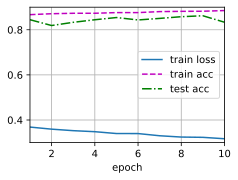

In [47]:
epoch=10

d2l.train_ch3(net,train,test,loss,epoch,trainer)

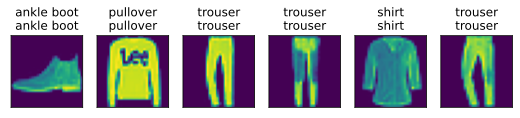

In [11]:
d2l.predict_ch3(net,test)

In [62]:
##build MLP using tools
##net
hidden_n1=256
output_n=10
lr=0.1
batchsize=256

net=nn.Sequential(nn.Flatten(),
                  nn.Linear(28*28,hidden_n1),
                  nn.Sigmoid(),
                  nn.Linear(hidden_n1,output_n))
def init_weight(m):
    if(m==nn.Linear):
        nn.init.normal_(m.weight,std=0.1)
net.apply(init_weight)

#
loss=nn.CrossEntropyLoss()
trainer=torch.optim.SGD(net.parameters(),lr=lr)

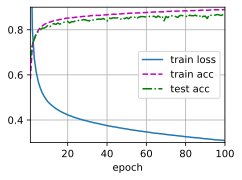

In [63]:
epoch=100
d2l.train_ch3(net,train,test,loss,epoch,trainer)

In [43]:
#####regularization
##genera data
train_n,test_n,input_n,batchsize=20,100,200,5
w_true,b_true=torch.ones(size=(input_n,1))*0.01,0.05
train_data=d2l.synthetic_data(w_true,b_true,train_n)
train_iter=d2l.load_array(train_data,batchsize,is_train=True)
test_data=d2l.synthetic_data(w_true,b_true,test_n)
test_iter=d2l.load_array(test_data,batchsize,is_train=False)

In [44]:
###init w,b
def init_wb():
    w=torch.normal(0,1,size=(input_n,1),requires_grad=True)
    b=torch.zeros((1,1),requires_grad=True)
    return [w,b]

###regularization
def l2_penality(w):
    return ((w**2).sum())/2

def train(lamda):
    w,b=init_wb()
    net,loss=lambda X: d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs,lr=100,0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for i in range(num_epochs):
        for X,y in train_iter:
            with torch.enable_grad():
                y_hat=net(X)
                l=loss(y_hat,y)+lamda*l2_penality(w)
                l.sum().backward()
                d2l.sgd([w,b],lr=lr,batch_size=batchsize)
        animator.add(i+1,(d2l.evaluate_loss(net,train_iter,loss),
                          d2l.evaluate_loss(net,test_iter,loss)))
        

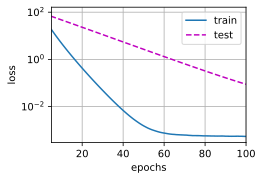

In [45]:
train(lamda=3)

In [61]:
##concise
def train_concise(lamda):
    net=nn.Sequential(nn.Linear(input_n,1))
    for param in net.parameters():
        param.data.normal_(0,1)
    loss=nn.MSELoss()
    num_epochs,lr=100,0.003
    trainer=torch.optim.SGD([{'params':net[0].weight,
                             'weight_decay':lamda},
                             {'params':net[0].bias}],lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            y_hat=net(X)
            l=loss(y_hat,y)
            with torch.enable_grad():
                trainer.zero_grad()
                l.backward()
            trainer.step()
        animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),
                              d2l.evaluate_loss(net,test_iter,loss)))    

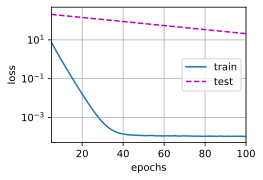

In [62]:
train_concise(lamda=1)

In [130]:
##drop out
def drop_out(X,p):
    assert 1>=p>=0
    if(p==1):
        return X
    if(p==0):
        return torch.zeros_like(X)
    X[torch.Tensor(X.shape).uniform_(0,1)<p]=0
    return X
#print(drop_out(torch.normal(0,1,(2,5)),0.5))  

##net parameters
input_n,hidden_n1,hidden_n2,output_n=28*28,256,256,10
drop_out_p1,drop_out_p2=0.5,0.2
class drop_out_net(nn.Module):
    def __init__(self,input_n,hidden_n1,hidden_n2,output_n,is_train=True):
        super(drop_out_net,self).__init__()
        self.is_train=is_train
        self.input_n=input_n
        self.H1=nn.Linear(input_n,hidden_n1)
        self.H2=nn.Linear(hidden_n1,hidden_n2)
        self.out=nn.Linear(hidden_n2,output_n)
        self.relu=nn.ReLU()
        
    def forward(self,X):
        H1=self.relu(self.H1(X.reshape(-1,input_n)))
        if(self.is_train):
            #H1=drop_out(H1,drop_out_p1)
            a=0.5
            std,mean=torch.abs(H1)**0.5*(1-a*a)**0.5,torch.zeros_like(H1)+(1-a)*H1
            H1=H1*a+torch.normal(mean,std)
        H2=self.relu(self.H2(H1))
        if(self.is_train):
            #H2=drop_out(H2,drop_out_p2)
            a=0.8
            std,mean=torch.abs(H2)**0.5*(1-a*a)**0.5,torch.zeros_like(H2)+(1-a)*H2
            H2=H2+torch.normal(mean,std)
        return self.out(H2)         

In [122]:
?torch.abs

Docstring:
abs(input, *, out=None) -> Tensor

Computes the absolute value of each element in :attr:`input`.

.. math::
    \text{out}_{i} = |\text{input}_{i}|

Args:
    input (Tensor): the input tensor.

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> torch.abs(torch.tensor([-1, -2, 3]))
    tensor([ 1,  2,  3])
Type:      builtin_function_or_method


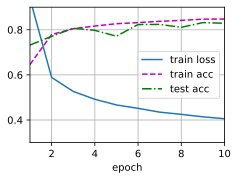

In [131]:
##train:
net=drop_out_net(input_n,hidden_n1,hidden_n2,output_n,is_train=True)
epoch=10
loss=nn.CrossEntropyLoss()
trainer=torch.optim.SGD(net.parameters(),lr=0.5)
d2l.train_ch3(net,train,test,loss,epoch,trainer)

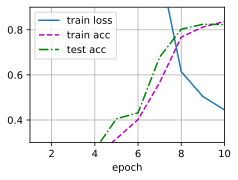

In [133]:
###concise
drop_out_p1,drop_out_p2=0.5,0.2
net=nn.Sequential(nn.Flatten(),
                  nn.Linear(input_n,  hidden_n1),nn.ReLU(),nn.Dropout(drop_out_p1),
                  nn.Linear(hidden_n1,hidden_n2),nn.ReLU(),nn.Dropout(drop_out_p2),
                  nn.Linear(hidden_n2,output_n) )
def init_weight(m):
    if(type(m)==nn.Linear):
        nn.init.zeros_(m.weight)
net.apply(init_weight)
epoch=10
trainer=torch.optim.SGD(net.parameters(),lr=0.5)
d2l.train_ch3(net,train,test,loss,epoch,trainer)